# Data Parallel and Fully Sharded Data Parallel Training

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-181717?style=flat-square&logo=github)](https://github.com/sshkhr/MinText/blob/main/docs/tutorials/2_Data_Parallel_and_FSDP.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sshkhr/MinText/blob/main/docs/tutorials/2_Data_Parallel_and_FSDP.ipynb)

In the previous tutorial, we explored the basics of JAX parallelization, including device meshes, sharded matrices, and collective operations. In this tutorial, we'll build on those concepts to explore the first parallelism strategy used in scaling models: data parallelism (DP). We will also learn about how to profile distributed machine learning in order to identify potential bottlenecks.


## 0. Setup

Let's start by importing the necessary libraries and initializing our environment.

In [1]:
import os
# Force JAX to see 8 devices for this tutorial (only use if not using TPU runtime)
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental import mesh_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial

In [2]:
# Check available devices
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()[:4]}...")
print(f"Number of devices: {jax.device_count()}")

JAX version: 0.5.2
Available devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1)]...
Number of devices: 8


### Model Representation

For simplicity, we will start with a simple feed-forward model. The model consists of two fully-connected (or dense) layers:

- **W<sub>in</sub>**: `bf16[D, F]` (up-projection)
- **W<sub>out</sub>**: `bf16[F, D]` (down-projection)

And the input and output are defined as:
- **Input**: `bf16[B, D]`
- **Out**: `bf16[B, D]`

Where:
- **D** = d<sub>model</sub> (input/output dimension)
- **F** = d<sub>ff</sub> (feed-forward or hidden dimension)
- **B** = batch size (total tokens)


![MLP](https://github.com/jax-ml/scaling-book/blob/main/assets/img/simple-transformer.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

# 1. Why Parallelism?

## Communication vs Computation Trade-offs

The goal of scaling is to achieve **strong scaling**: linear increase in throughput with more chips. Performance depends on hiding inter-chip communication by overlapping it with useful FLOPs.

We become **compute-bound** when:
$$\frac{T_{\text{math}}}{T_{\text{comms}}} > 1$$

# 2. Data Parallel

The key insight is that computation time scales with batch size, while communication time is often independent of batch size (since we transfer model weights)."

### Data Parallelism Theory

**Definition**: Activations sharded along batch dimension, parameters replicated on each device. Communication only occurs during the backward pass.

**Mathematical representation**:
$$\text{In}[B_X, D] \cdot_D W_{\text{in}}[D, F] \cdot_F W_{\text{out}}[F, D] \rightarrow \text{Out}[B_X, D]$$

where $B_X$ indicates the batch is sharded across $X$ devices.

![Data Parallelism](https://github.com/jax-ml/scaling-book/blob/main/assets/img/data-parallelism.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

### Algorithm:

**Forward pass:**
1. Tmp[B<sub>X</sub>, F] = In[B<sub>X</sub>, D] ×<sub>D</sub> W<sub>in</sub>[D, F]
2. Out[B<sub>X</sub>, D] = Tmp[B<sub>X</sub>, F] ×<sub>F</sub> W<sub>out</sub>[F, D]

**Backward pass:**
1. dW<sub>out</sub>[F, D] = **AllReduce**(Tmp[B<sub>X</sub>, F] ×<sub>B</sub> dOut[B<sub>X</sub>, D])
2. dW<sub>in</sub>[D, F] = **AllReduce**(In[B<sub>X</sub>, D] ×<sub>B</sub> dTmp[B<sub>X</sub>, F])

**Key properties**:
- Forward pass requires **no communication**
- Backward pass requires **AllReduce on gradients**
- Model parameters and optimizer states are fully replicated
- Memory usage scales with number of devices


**When do we become communication-bound?**

For TPUv5p with $C = 4.6 \times 10^{14}$ FLOPs/s and $W = 2 \times 9 \times 10^{10}$ bytes/s:

$$\frac{B}{X} > \frac{C}{W_{\text{ici}}} = 2550$$

So our **batch size per chip must be at least 2,550** to avoid being communication-bound with 1D data parallelism.

**Limitations**: Largest model we can train has approximately $\text{HBM per device} / 10$ parameters (≈9B for TPUv5p with Adam optimizer)."

# 3. Example: 8-way Data Parallel Training with Plain JAX

Data parallelism is a strategy where we replicate the model across multiple devices and shard the data batch. Each device processes a portion of the batch using its copy of the model, and then we aggregate the gradients across all devices.

Let's implement 8-way data parallel training, following the approach in `jax_data_parallel.py`.

### 3.1 Create (fake) data and define Model

First, let's generate our synthetic dataset and simple feed-forward neural network.

In [3]:
def get_linear_layer(key, dim_in, dim_hidden):
  k1, k2 = jax.random.split(key)
  W = jax.random.normal(k1, (dim_in, dim_hidden)) / jnp.sqrt(dim_in)
  b = jax.random.normal(k2, (dim_hidden,))
  return W, b

def get_model_and_data(key, layer_sizes, batch_size):
  keys, *keys = jax.random.split(key, len(layer_sizes))

  model = list(map(get_linear_layer, keys, layer_sizes[:-1], layer_sizes[1:]))

  keys, *keys = jax.random.split(key, 2)
  input_data = jax.random.normal(keys[0], (batch_size, layer_sizes[0]))
  target_data = jax.random.normal(keys[0], (batch_size, layer_sizes[-1]))

  return model, (input_data, target_data)

In [4]:
layer_sizes = [768, 4*768, 768]
batch_size = 8192

In [5]:
model, batch = get_model_and_data(jax.random.key(0), layer_sizes, batch_size)

In [6]:
def predict(model, inputs):
  for W, b in model:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  return outputs

def loss(model, batch):
  inputs, targets = batch
  predictions = predict(model, inputs)
  return jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))

In [7]:
loss_jit = jax.jit(loss)
gradfun = jax.jit(jax.grad(loss))

### 3.2 Single-Device Baseline

Let's first establish a baseline by training on a single device.

In [8]:
batch_single = jax.device_put(batch, jax.devices()[0])
params_single = jax.device_put(model, jax.devices()[0])

In [9]:
loss_jit(params_single, batch_single)

Array(2324.8494, dtype=float32)

In [17]:
%timeit -n 5 -r 5 gradfun(params_single, batch_single)[0][0].block_until_ready()

10.8 ms ± 1.08 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


### 3.3 8-way Data Parallel Training

Now let's implement 8-way data parallel training where we'll shard the batch across 8 devices.

In [11]:
# Create an 8-device mesh for data parallelism
mesh = jax.make_mesh((8,), ('batch',))
print(f"Mesh shape: {mesh.shape}")
print(f"Mesh axis names: {mesh.axis_names}")

# Create sharding specifications

## Shard data along the batch dimension
batch_sharding = NamedSharding(mesh, P('batch'))
## Replicate parameters across all devices
replicated_sharding = NamedSharding(mesh, P())

Mesh shape: OrderedDict([('batch', 8)])
Mesh axis names: ('batch',)


In [12]:
batch = jax.device_put(batch, batch_sharding)
params = jax.device_put(model, replicated_sharding)

In [13]:
loss_jit(params, batch)

Array(2324.849, dtype=float32)

In [18]:
%timeit -n 5 -r 5 gradfun(params, batch)[0][0].block_until_ready()

3.29 ms ± 60.7 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [22]:
step_size = 1e-4

for _ in range(1000):
  grads = gradfun(params, batch)
  params = [(W - step_size * dW, b - step_size * db)
            for (W, b), (dW, db) in zip(params, grads)]

print(loss_jit(params, batch))

527.20404


### 1.4 Visualizing Data Sharding

Let's visualize how the batch is sharded across devices.

In [28]:
print("Visualizing batch sharding across 8 devices:")
print("Original batch shape:", batch[0].shape)

for shard in batch[0].addressable_shards:
  print(shard.device, shard.index[0], shard.data.shape)

Visualizing batch sharding across 8 devices:
Original batch shape: (8192, 768)
TPU_0(process=0,(0,0,0,0)) slice(0, 1024, None) (1024, 768)
TPU_1(process=0,(0,0,0,1)) slice(1024, 2048, None) (1024, 768)
TPU_2(process=0,(1,0,0,0)) slice(2048, 3072, None) (1024, 768)
TPU_3(process=0,(1,0,0,1)) slice(3072, 4096, None) (1024, 768)
TPU_6(process=0,(1,1,0,0)) slice(4096, 5120, None) (1024, 768)
TPU_7(process=0,(1,1,0,1)) slice(5120, 6144, None) (1024, 768)
TPU_4(process=0,(0,1,0,0)) slice(6144, 7168, None) (1024, 768)
TPU_5(process=0,(0,1,0,1)) slice(7168, 8192, None) (1024, 768)


## 2. Data Parallel Training with Flax NNX

Now let's implement the same 8-way data parallel training using Flax NNX, which provides higher-level abstractions.

In [30]:
# Import Flax NNX
try:
    import flax.nnx as nnx
    import optax
except ImportError:
    !pip install -q flax optax
    import flax.nnx as nnx
    import optax

In [31]:
# create model
class MLP(nnx.Module):
  def __init__(self, din, dmid, dout, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    return self.linear2(nnx.relu(self.linear1(x)))

In [32]:
model = MLP(1, 64, 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adamw(1e-2))

# replicate state
state = nnx.state((model, optimizer))
state = jax.device_put(state, replicated_sharding)
nnx.update((model, optimizer), state)

In [33]:
# visualize model sharding
print('model sharding')
jax.debug.visualize_array_sharding(model.linear1.kernel.value)

model sharding


                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                              TPU 0,1,2,3,4,5,6,7                               
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                

In [34]:
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, x, y):
  def loss_fn(model: MLP):
    y_pred = model(x)
    return jnp.mean((y - y_pred) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)
  return loss


def dataset(steps, batch_size):
  for _ in range(steps):
    x = np.random.uniform(-2, 2, size=(batch_size, 1))
    y = 0.8 * x**2 + 0.1 + np.random.normal(0, 0.1, size=x.shape)
    yield x, y

In [35]:
for step, (x, y) in enumerate(dataset(1000, 16)):
  # shard data
  x, y = jax.device_put((x, y), batch_sharding)
  # train
  loss = train_step(model, optimizer, x, y)

  if step == 0:
    print('data sharding')
    jax.debug.visualize_array_sharding(x)

  if step % 100 == 0:
    print(f'step={step}, loss={loss}')

data sharding


  TPU 0  
         
  TPU 1  
         
  TPU 2  
         
  TPU 3  
         
  TPU 6  
         
  TPU 7  
         
  TPU 4  
         
  TPU 5  
         

step=0, loss=3.0337131023406982
step=100, loss=0.04082110896706581
step=200, loss=0.03399622440338135
step=300, loss=0.016794903203845024
step=400, loss=0.02406255342066288
step=500, loss=0.013983037322759628
step=600, loss=0.01109331101179123
step=700, loss=0.024920038878917694
step=800, loss=0.012097254395484924
step=900, loss=0.008098714053630829


In [36]:
# dereplicate state
state = nnx.state((model, optimizer))
state = jax.device_get(state)
nnx.update((model, optimizer), state)

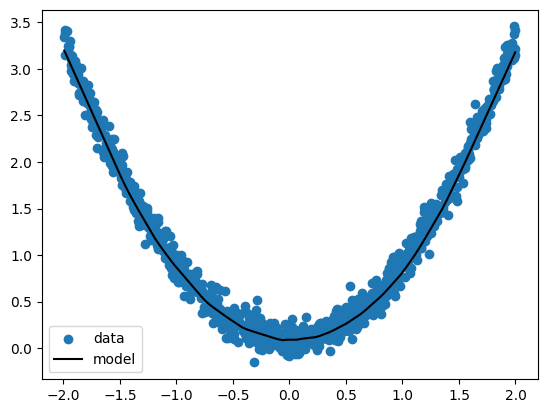

In [37]:
X, Y = next(dataset(1, 1000))
x_range = np.linspace(X.min(), X.max(), 100)[:, None]
y_pred = model(x_range)

# plot
plt.scatter(X, Y, label='data')
plt.plot(x_range, y_pred, color='black', label='model')
plt.legend()
plt.show()

### Fully Sharded Data Parallelism (FSDP) Theory

**Definition**: Activations, weights, and optimizer states are sharded along batch dimension. Weights are gathered just-in-time before use.

**Mathematical representation**:
$$\text{In}[B_X, D] \cdot_D W_{\text{in}}[D_X, F] \cdot_F W_{\text{out}}[F, D_X] \rightarrow \text{Out}[B_X, D]$$

where both batch and weight dimensions are sharded across $X$ devices.

![FSDP](https://github.com/jax-ml/scaling-book/blob/main/assets/img/fsdp.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

**Key properties**:
- **Drastically reduces per-device memory usage**
- Saves on backward pass FLOPs
- Decomposes AllReduce into AllGather + ReduceScatter
- Same communication cost as pure data parallelism
- Also called \"ZeRO sharding\" (ZeRO-3 shards parameters, gradients, and optimizer states)

**Algorithm**:

**Forward pass:**
1. W<sub>in</sub>[D, F] = **AllGather**(W<sub>in</sub>[D<sub>X</sub>, F])
2. Tmp[B<sub>X</sub>, F] = In[B<sub>X</sub>, D] ×<sub>D</sub> W<sub>in</sub>[D, F]
3. W<sub>out</sub>[F, D] = **AllGather**(W<sub>out</sub>[F, D<sub>X</sub>])
4. Out[B<sub>X</sub>, D] = Tmp[B<sub>X</sub>, F] ×<sub>F</sub> W<sub>out</sub>[F, D]

**Backward pass:**
1. dW<sub>out</sub>[F, D<sub>X</sub>] = **ReduceScatter**(Tmp[B<sub>X</sub>, F] ×<sub>B</sub> dOut[B<sub>X</sub>, D])
2. dW<sub>in</sub>[D<sub>X</sub>, F] = **ReduceScatter**(dTmp[B<sub>X</sub>, F] ×<sub>B</sub> In[B<sub>X</sub>, D])

**Communication Analysis**:

FSDP has the **same roofline as pure data parallelism** because:
- AllReduce = AllGather + ReduceScatter
- Total communication volume is identical
- Same condition: $\frac{B}{X} > \frac{C}{W_{\text{ici}}} = 2550$

**Benefits**:
- Memory reduction: Parameters and optimizer states sharded across devices
- Zero overhead: Same FLOPs-to-communication ratio
- Can upgrade from data parallelism without performance loss
- Essential for models > 9B parameters"

## 3. Fully Sharded Data Parallel (FSDP) Training with Flax NNX

Now let's implement FSDP where we shard both the data and model parameters across devices. This is especially useful for large models that don't fit on a single device.

### Understanding FSDP Memory Benefits

The diagram below shows how FSDP reduces memory usage compared to pure data parallelism:

![FSDP Memory Comparison](https://github.com/jax-ml/scaling-book/blob/main/assets/img/fsdp-figure.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

The rows show:
1. **Pure Data Parallelism**: Parameters and optimizer states fully replicated
2. **ZeRO-1**: Optimizer states sharded
3. **ZeRO-2**: Optimizer states and gradients sharded  
4. **ZeRO-3 (FSDP)**: Parameters, gradients, and optimizer states all sharded

**Why FSDP matters**: Standard data parallelism involves significant duplicated work and memory. With FSDP:
- Each device only stores 1/N of the parameters
- Each device only updates 1/N of the optimizer state
- AllGather parameters as needed for forward pass
- ReduceScatter gradients for efficient updates

This enables training much larger models that wouldn't fit with pure data parallelism."

In [ ]:
# Create a 2D mesh for FSDP
# We'll use 2 devices for data parallelism and 4 for model parallelism
fsdp_mesh = jax.sharding.Mesh(
    mesh_utils.create_device_mesh((2, 4)),
    ('data', 'model')
)
print(f"FSDP mesh shape: {fsdp_mesh.shape}")
print(f"FSDP mesh axis names: {fsdp_mesh.axis_names}")

In [ ]:
# Define a custom MLP with explicit parameter sharding for FSDP
import dataclasses
from typing import Optional

@dataclasses.dataclass(unsafe_hash=True)
class MeshRules:
    """Rules for how to shard different parts of the model."""
    input_dim: Optional[str] = None
    output_dim: Optional[str] = 'model'
    bias: Optional[str] = 'model'

mesh_rules = MeshRules()

class FSDP_MLP(nnx.Module):
    """MLP with explicit parameter sharding for FSDP."""

    def __init__(self, layer_sizes, rngs: nnx.Rngs):
        self.layer_sizes = layer_sizes

        # Create layers with sharded parameters
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            in_dim, out_dim = layer_sizes[i], layer_sizes[i + 1]

            # Initialize weight with sharding spec
            w = nnx.Param(
                nnx.initializers.lecun_normal()(rngs.params(), (in_dim, out_dim)),
                sharding=(mesh_rules.input_dim, mesh_rules.output_dim)
            )

            # Initialize bias with sharding spec
            # For the last layer with output_dim=1, we don't shard
            if out_dim == 1:
                b = nnx.Param(
                    jnp.zeros((out_dim,)),
                    sharding=(None,)  # Don't shard single-element bias
                )
            else:
                b = nnx.Param(
                    jnp.zeros((out_dim,)),
                    sharding=(mesh_rules.bias,)
                )

            self.weights.append(w)
            self.biases.append(b)

    def __call__(self, x):
        activations = x

        # Apply each layer
        for i in range(len(self.weights) - 1):
            activations = jnp.dot(activations, self.weights[i]) + self.biases[i]
            activations = jax.nn.relu(activations)

        # Last layer
        return jnp.dot(activations, self.weights[-1]) + self.biases[-1]

In [ ]:
# Custom SGD optimizer for FSDP (based on flax_nnx_dp_fsdp.py)
class SGDState(nnx.Variable):
    pass

class SGD(nnx.Object):
    def __init__(self, params: nnx.State, lr, decay=0.9):
        def init_optimizer_state(variable: nnx.Variable):
            return SGDState(
                jnp.zeros_like(variable.value), **variable.get_metadata()
            )

        self.lr = lr
        self.params = params
        self.momentum: nnx.State = jax.tree.map(init_optimizer_state, self.params)
        self.decay = decay

    def update(self, grads: nnx.State):
        def update_fn(params: nnx.Variable, momentum: SGDState, grad: nnx.VariableState):
            # Momentum update
            momentum.value = self.decay * momentum + (1 - self.decay) * grad.value
            # Parameter update
            params.value -= self.lr * momentum

        jax.tree.map(update_fn, self.params, self.momentum, grads)

### Mixed FSDP and Tensor Parallelism

For even larger models or smaller batch sizes, we can combine FSDP with tensor parallelism using a 2D mesh:

![Mixed FSDP and Tensor Parallelism](https://github.com/jax-ml/scaling-book/blob/main/assets/img/mixed-fsdp-model-parallelism.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

**Mathematical representation**:
$$\text{In}[B_X, D_Y] \cdot_D W_{\text{in}}[D_X, F_Y] \cdot_F W_{\text{out}}[F_Y, D_X] \rightarrow \text{Out}[B_X, D_Y]$$

where:
- $X$ = data/FSDP parallelism dimension
- $Y$ = model/tensor parallelism dimension

**Key insight**:
- **FSDP moves weights** (communication scales with weight size)
- **Tensor parallelism moves activations** (communication scales with activation size)
- As batch size shrinks, activations get smaller → tensor parallelism becomes cheaper
- As we add more tensor parallelism, weight gathers get smaller → FSDP becomes cheaper

**Optimal sharding**: For $N = X \times Y$ total chips:
$$X_{\text{opt}} = \sqrt{\frac{B}{F} \frac{M_X}{M_Y} N}$$

where $M_X$ and $M_Y$ are the number of mesh axes for FSDP and tensor parallelism respectively.

**Communication bound condition**:
$$\frac{B}{N} > \frac{4\alpha^2}{M_X M_Y F}$$

where $\alpha = C/W_{\text{ici}} = 2550$ for TPUv5p.

This allows batch sizes as low as ~400 tokens per chip, roughly 2× better than pure FSDP."

In [ ]:
# Create and initialize FSDP model
@nnx.jit
def create_fsdp_model():
    # Use smaller layer sizes for FSDP demo to avoid memory issues
    fsdp_layer_sizes = [input_dim, 1024, 512, 1]
    model = FSDP_MLP(fsdp_layer_sizes, rngs=nnx.Rngs(0))
    optimizer = SGD(nnx.variables(model, nnx.Param), learning_rate, decay=0.9)

    # Get sharding specifications for the state
    state = nnx.state(optimizer)

    def get_named_shardings(path: tuple, value: nnx.VariableState):
        if hasattr(value, 'sharding') and value.sharding is not None:
            return value.replace(NamedSharding(fsdp_mesh, P(*value.sharding)))
        return value

    named_shardings = nnx.map_state(get_named_shardings, state)
    sharded_state = jax.lax.with_sharding_constraint(state, named_shardings)
    nnx.update(optimizer, sharded_state)

    return model, optimizer

print("Creating FSDP model...")
fsdp_model, fsdp_optimizer = create_fsdp_model()

# Visualize parameter sharding
print("
Weight sharding (distributed across model axis):")
jax.debug.visualize_array_sharding(fsdp_model.weights[0].value)
print("
Momentum sharding:")
jax.debug.visualize_array_sharding(fsdp_optimizer.momentum['weights'][0].value)

In [ ]:
# FSDP training step
@nnx.jit
def fsdp_train_step(model: FSDP_MLP, optimizer: SGD, x_batch, y_batch):
    """FSDP training step."""
    def loss_fn(model):
        predictions = model(x_batch)
        return jnp.mean((predictions - y_batch) ** 2)

    loss_value, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss_value

# Training with FSDP
print("
Training with FSDP...")
losses_fsdp = []
start_time = time.time()

# Use smaller batch size for FSDP demo
fsdp_batch_size = 256
steps_per_epoch = num_samples // fsdp_batch_size

for epoch in range(num_epochs):
    # Shuffle data
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, num_samples)
    x_shuffled = x_data[perm]
    y_shuffled = y_data[perm]

    epoch_losses = []

    for step in range(steps_per_epoch):
        # Get batch
        idx_start = step * fsdp_batch_size
        idx_end = idx_start + fsdp_batch_size
        x_batch = x_shuffled[idx_start:idx_end]
        y_batch = y_shuffled[idx_start:idx_end]

        # Shard data across the data axis only
        data_sharding = NamedSharding(fsdp_mesh, P('data', None))
        x_batch = jax.device_put(x_batch, data_sharding)
        y_batch = jax.device_put(y_batch, data_sharding)

        # Perform training step
        loss = fsdp_train_step(fsdp_model, fsdp_optimizer, x_batch, y_batch)
        epoch_losses.append(float(loss))

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses_fsdp.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

end_time = time.time()
time_fsdp = end_time - start_time
print(f"
FSDP training time: {time_fsdp:.2f} seconds")

## 4. Performance Comparison

Let's compare the performance of all training approaches.

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(losses_single, label='Single Device', linewidth=2)
plt.plot(losses_dp, label='JAX Data Parallel (8-way)', linewidth=2)
plt.plot(losses_nnx_dp, label='Flax NNX Data Parallel (8-way)', linewidth=2)
plt.plot(losses_fsdp, label='Flax NNX FSDP', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot speedup comparison
plt.subplot(1, 2, 2)
methods = ['Single
Device', 'JAX
DP', 'Flax NNX
DP', 'FSDP']
times = [time_single, time_dp, time_nnx_dp, time_fsdp]
speedups = [time_single / t for t in times]
colors = ['gray', 'blue', 'green', 'red']

bars = plt.bar(methods, speedups, color=colors, alpha=0.7)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.ylabel('Speedup (relative to single device)')
plt.title('Training Speedup Comparison')
plt.grid(True, alpha=0.3, axis='y')

# Add speedup values on bars
for bar, speedup in zip(bars, speedups):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{speedup:.2f}x', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("
=== Performance Summary ===")
print(f"Single Device: {time_single:.2f}s")
print(f"JAX Data Parallel (8-way): {time_dp:.2f}s (speedup: {time_single/time_dp:.2f}x)")
print(f"Flax NNX Data Parallel (8-way): {time_nnx_dp:.2f}s (speedup: {time_single/time_nnx_dp:.2f}x)")
print(f"FSDP: {time_fsdp:.2f}s (speedup: {time_single/time_fsdp:.2f}x)")

### Communication vs Computation Analysis

The plot below shows how different parallelism strategies perform as batch size changes:

![Communication vs FLOPs Analysis](https://github.com/jax-ml/scaling-book/blob/main/assets/img/mixed-fsdp-comms-2.png?raw=true)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

Key observations:
- **Pure Data Parallelism/FSDP** (green): Ratio scales linearly with batch size. Best for large batches.
- **Tensor Parallelism** (blue): Fixed ratio independent of batch size. Limited by feed-forward dimension.
- **Mixed FSDP + Tensor Parallelism** (red): Ratio scales with √B. Optimal for intermediate batch sizes.

**The horizontal line at ratio = 1** marks the boundary between compute-bound (above) and communication-bound (below) regimes.

**Practical implications**:
- Large batch sizes (>850 per chip): Use pure FSDP
- Intermediate batch sizes (400-850 per chip): Use mixed FSDP + tensor parallelism
- Very small batch sizes: May become communication-bound regardless

This analysis helps choose the right parallelism strategy based on your model size, batch size, and available hardware."

### Summary: Parallelism Strategies Comparison

Here's a comprehensive comparison of the parallelism strategies covered:

| **Strategy** | **Mathematical Formula** | **Communication** | **Memory** | **Best Use Case** |
|--------------|---------------------------|-------------------|------------|-------------------|
| **Data Parallelism** | In[B<sub>X</sub>, D] ⋅ W[D, F] → Out[B<sub>X</sub>, D] | AllReduce gradients (backward only) | Parameters replicated | Model fits on single device |
| **FSDP** | In[B<sub>X</sub>, D] ⋅ W[D<sub>X</sub>, F] → Out[B<sub>X</sub>, D] | AllGather weights + ReduceScatter grads | Parameters sharded | Large models, memory constraints |
| **Tensor Parallelism** | In[B, D<sub>Y</sub>] ⋅ W[D, F<sub>Y</sub>] → Out[B, D<sub>Y</sub>] | AllGather activations + ReduceScatter | Weights sharded by FF dim | Small batch sizes |
| **Mixed FSDP + TP** | In[B<sub>X</sub>, D<sub>Y</sub>] ⋅ W[D<sub>X</sub>, F<sub>Y</sub>] → Out[B<sub>X</sub>, D<sub>Y</sub>] | Both weight and activation movement | Both sharding strategies | Very large models, small batches |

**Communication Bound Conditions** (for TPUv5p):
- **Data Parallelism & FSDP**: Batch size per chip > 2,550
- **Tensor Parallelism**: F > Y × 2,550 (typically 8-16 way max)
- **Mixed FSDP + TP**: Batch size per chip > 400 (optimal combination)

**Key Insight**: The choice of parallelism strategy depends on the interplay between:
1. **Model size** (does it fit on one device?)
2. **Batch size** (how much data per device?)
3. **Hardware constraints** (memory, bandwidth, number of devices)

For this tutorial's examples, we demonstrated the progression from simple data parallelism to more sophisticated FSDP approaches, showing how each strategy addresses different scaling challenges."

## 5. Key Takeaways

In this tutorial, we've explored different approaches to parallel training:

1. **8-way Data Parallel with Plain JAX**
   - Simple to implement using `jax.jit` and sharding specifications
   - Model is replicated across all devices
   - Data is sharded along the batch dimension
   - Good speedup for compute-intensive workloads

2. **Data Parallel with Flax NNX**
   - Higher-level API makes implementation cleaner
   - Same performance as plain JAX implementation
   - Better for complex models with many components

3. **Fully Sharded Data Parallel (FSDP) with Flax NNX**
   - Shards both model parameters and data
   - Uses a 2D mesh (data × model axes)
   - Essential for large models that don't fit on single device
   - More complex but enables training of massive models

### When to Use Each Approach:

- **Data Parallel**: When your model fits on a single device and you want to scale training speed
- **FSDP**: When your model is too large for a single device or you need maximum memory efficiency

### References:
- Example implementations: `jax_data_parallel.py` and `flax_nnx_dp_fsdp.py` in the root directory
- JAX documentation on [distributed arrays and automatic parallelization](https://jax.readthedocs.io/en/latest/jax-101/08-pjit.html)
- Flax NNX documentation on [distributed training](https://flax.readthedocs.io/en/latest/nnx/index.html)